In [1]:
"""

This notebook contains code an outputs for the following questions: 
10,12,13,14,15,34,35,39
"""

'\n\nThis notebook contains code an outputs for the following questions: \n10,12,13,14,15,34,35,39\n'

In [11]:
# General Functions
from surprise import Reader, Dataset,accuracy
from surprise import KNNBasic,KNNWithMeans, evaluate
from surprise.model_selection import cross_validate
import numpy as np
from surprise.model_selection import KFold
import pandas as pd    
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

#import surprise
# Define the format

def getPopular(testset,n):
    movie,freq=np.unique(np.array(testset)[:,1],return_counts=True)
    a=zip(movie,freq)
    pop=map(lambda y:y[0],filter(lambda x:x[1]>n,a))
    t=filter(lambda x:x[1] in pop,testset)
    return t


def getUnpopular(testset,n):
    movie,freq=np.unique(np.array(testset)[:,1],return_counts=True)
    a=zip(movie,freq)
    pop=map(lambda y:y[0],filter(lambda x:x[1]<=n,a))
    t=filter(lambda x:x[1] in pop,testset)
    return t


def getHighVariance(testset):
    testset=getPopular(testset,4)
    ans=(pd.DataFrame.from_records(testset).groupby(1)[2].var(ddof=False))
    af=pd.DataFrame.from_records(np.transpose([ans.index,ans.values]))
    high_var=af[af[1]>2]
    high_var=high_var[0]
    high_var=list(high_var)
    t=filter(lambda x:x[1] in high_var,testset)
    return t
    
def plot_error(rmse, mae, k_arr,c_name):
    #x, y, _ = roc_curve(actual, predicted)
    
    plt.plot(k_arr, rmse, label="RMSE")
    plt.plot(k_arr, mae, label="MAE")
    #plt.xlim([0.0, 1.0])
    #plt.ylim([0.0, 1.2])
    plt.xlabel('k')
    plt.ylabel('Error')
    plt.title("RMSE and MAE")
    plt.legend(loc="best")

    plt.savefig('plots/KNN Error for Question'+c_name+'.png', format='png')
    plt.show()

def classify_into_two_class(data,threshold):
    
    temp_data=[]
    
    for i in range(len(data)):
        #print data[i]
        
        if float(data[i]) < threshold :
            temp_data.append(int(0))
         #   print "if true"
        else:
            temp_data.append(int(1))
          #  print "else true for threshold :"+str(threshold)
        #print data[i]
    return temp_data
        
def plot_roc(actual, predicted, classifier_name):
    x, y, _ = roc_curve(actual, predicted)
    
    plt.plot(x, y, label="ROC Curve")
    plt.plot([0, 1], [0, 1])
    #plt.xlim([0.0, 1.0])
    #plt.ylim([0.0, 1.2])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(classifier_name)
    plt.legend(loc="best")

    plt.savefig('plots/KNN ' + classifier_name + '.png', format='png')
    plt.show()

def plot_prec_rec(actual, predicted, classifier_name):
    x, y, _ = precision_recall_curve(actual, predicted)
    
    plt.plot(x, y, label="Precision Recall Curve")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(classifier_name)
    plt.legend(loc="best")

    plt.savefig('plots/' + classifier_name + '.png', format='png')
    plt.show()
    
def getPR(predictions,k):
    userliked = defaultdict(list)
    actualliked=defaultdict(list)
    al=defaultdict(list)
    ul=defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        userliked[uid].append((iid, est))
        actualliked[uid].append((iid,true_r))

    for uid, user_ratings in userliked.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        #u=filter(lambda x:x[1]>3,user_ratings)
        u=map(lambda x:x[0],user_ratings)
        if len(u)>0:
            ul[uid] = u
    for uid, user_ratings in actualliked.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        u=filter(lambda x:x[1]>3,user_ratings)
        u=map(lambda x:x[0],u)
        if len(u)>0:
            al[uid] = u
    valid_users=[]
    map(lambda x:valid_users.append(x) ,al.keys())
    count=0
    prec=0
    rec=0
    recall=[]
    precision=[]
    for u in valid_users:
        if len(ul.get(u))>=k:
            prec=prec+(len(set(al.get(u))&set(ul.get(u)[:k]))*1.0/k)
            rec=rec+(len(set(al.get(u))&set(ul.get(u)[:k]))*1.0/len(al.get(u)))
            precision.append((len(set(al.get(u))&set(ul.get(u)[:5]))*1.0/k))
            recall.append((len(set(al.get(u))&set(ul.get(u)[:5]))*1.0/len(al.get(u))))
            count=count+1
    return prec/count,rec/count

def plot_PR_against_t(precision,recall, t_arr,c_name):
    #x, y, _ = roc_curve(actual, predicted)
    
    plt.plot(t_arr, precision, label="RMSE")
    plt.plot(t_arr, recall, label="MAE")
    #plt.xlim([0.0, 1.0])
    #plt.ylim([0.0, 1.2])
    plt.xlabel('k')
    plt.ylabel('Error')
    plt.title("Precision and Recall")
    plt.legend(loc="best")

    plt.savefig('plots/KNN Precision Recall vs t for task '+c_name+'.png', format='png')
    plt.show()
    
def plotgraph(array, t_arr,y_label,x_label, cname):
    #x, y, _ = roc_curve(actual, predicted)
    
    plt.plot(t_arr, array)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(cname)
    plt.legend(loc="best")

    plt.savefig('plots/KNN '+cname+'.png', format='png')
    plt.show()
    
def all_plots_rating(knn_prec, knn_rec, nnf_prec, nnf_rec, mf_prec,mf_rec):
    plt.plot(knn_rec,knn_prec, label="KNN")
    plt.plot(nnf_rec,nnf_prec, label="NNF")
    plt.plot(mf_rec,mf_prec, label="MF_Bias")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc="best")
    plt.title("Rating Comparison for KNN,NNF and MF with Bias")
    plt.savefig('plots/All Plots Rating - Precision vs Recall Task 39.png', format='png')
    plt.show()
    

def all_plots_roc(knn_actual, knn_predicted,nnf_actual, nnf_predicted,mf_actual, mf_predicted):
    x1, y1, _ = roc_curve(knn_actual, knn_predicted)
    x2, y2, _ = roc_curve(nnf_actual, nnf_predicted)
    x3, y3, _ = roc_curve(mf_actual, mf_predicted)
    
    plt.plot(x1, y1, label="KNN ROC Curve")
    plt.plot(x2, y2, label="NNF ROC Curve")
    plt.plot(x3, y3, label="MF_BIAS ROC Curve")
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title("Prediction Comparison for KNN,NNF and MF with Bias")
    plt.legend(loc="best")

    plt.savefig('plots/All Plots Prediction - Precision vs Recall Task 34.png', format='png')
    plt.show()
    


 for k = 2
Evaluating RMSE, MAE of algorithm KNNWithMeans on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
MAE (testset)     0.8142  0.8041  0.8104  0.8067  0.8006  0.8018  0.8081  0.8262  0.8195  0.8186  0.8110  0.0080  
RMSE (testset)    1.0564  1.0434  1.0500  1.0402  1.0452  1.0355  1.0475  1.0693  1.0643  1.0611  1.0513  0.0105  
Fit time          1.11    1.08    1.13    1.07    1.23    1.09    1.21    1.14    1.12    1.33    1.15    0.08    
Test time         0.86    0.86    0.85    1.02    0.89    0.89    0.87    0.86    0.96    0.98    0.90    0.06    
 for k = 4
Evaluating RMSE, MAE of algorithm KNNWithMeans on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
MAE (testset)     0.7483  0.7577  0.7626  0.7387  0.7466  0.7566  0.7526  0.7490  0.7521  0.7668  0.7531  0.0078  
RMSE (testset)    0.9676  0.9885  0.9897  0.9

Evaluating RMSE, MAE of algorithm KNNWithMeans on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
MAE (testset)     0.7039  0.6989  0.7186  0.7018  0.6930  0.6906  0.6969  0.6997  0.7026  0.6942  0.7000  0.0074  
RMSE (testset)    0.9228  0.9145  0.9416  0.9205  0.9084  0.9087  0.9147  0.9176  0.9237  0.9111  0.9184  0.0093  
Fit time          1.21    1.11    0.95    1.08    1.16    1.10    1.10    1.12    1.17    1.29    1.13    0.08    
Test time         1.49    1.62    1.46    1.48    1.27    1.44    1.35    1.57    1.48    1.26    1.44    0.11    
 for k = 30
Evaluating RMSE, MAE of algorithm KNNWithMeans on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
MAE (testset)     0.7073  0.6901  0.6997  0.6951  0.6997  0.7097  0.7000  0.7052  0.6951  0.6995  0.7002  0.0057  
RMSE (testset)    0.9224  0.9070  0.9123  0.9129  0.917

Evaluating RMSE, MAE of algorithm KNNWithMeans on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
MAE (testset)     0.7015  0.7016  0.6989  0.6997  0.7010  0.7003  0.7036  0.6970  0.6965  0.6989  0.6999  0.0021  
RMSE (testset)    0.9206  0.9190  0.9160  0.9178  0.9183  0.9209  0.9233  0.9093  0.9132  0.9190  0.9177  0.0038  
Fit time          1.15    1.02    1.17    1.13    1.39    1.15    1.25    1.19    1.20    1.32    1.20    0.10    
Test time         1.69    1.76    1.76    1.92    1.73    1.72    1.81    1.72    1.69    1.94    1.77    0.09    
 for k = 56
Evaluating RMSE, MAE of algorithm KNNWithMeans on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
MAE (testset)     0.7006  0.7089  0.6966  0.7010  0.7036  0.6932  0.6978  0.7009  0.6898  0.6955  0.6988  0.0052  
RMSE (testset)    0.9152  0.9288  0.9134  0.9184  0.926

Evaluating RMSE, MAE of algorithm KNNWithMeans on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
MAE (testset)     0.7094  0.7104  0.7000  0.6970  0.6904  0.7041  0.7017  0.7038  0.6906  0.6958  0.7003  0.0066  
RMSE (testset)    0.9297  0.9323  0.9160  0.9115  0.9043  0.9284  0.9171  0.9229  0.9058  0.9094  0.9177  0.0097  
Fit time          1.45    1.24    1.00    1.40    1.39    1.32    1.13    1.01    1.00    1.04    1.20    0.17    
Test time         2.17    2.06    1.94    2.04    2.20    2.22    1.52    1.46    1.49    1.59    1.87    0.30    
 for k = 82
Evaluating RMSE, MAE of algorithm KNNWithMeans on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
MAE (testset)     0.6997  0.7074  0.7000  0.7018  0.6878  0.6957  0.7078  0.6919  0.7022  0.7028  0.6997  0.0060  
RMSE (testset)    0.9197  0.9332  0.9190  0.9195  0.900

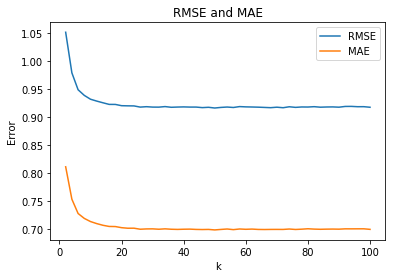

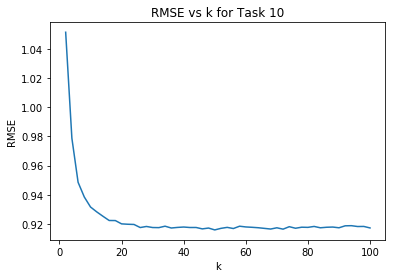

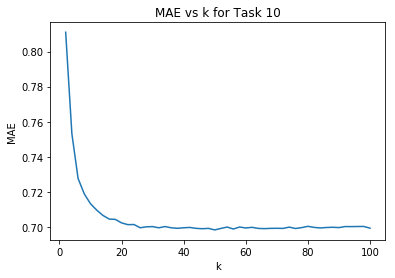

In [3]:
"""
Question 10: Design a k-NN collaborative lter to predict the ratings of the movies in the MovieLens dataset and evaluate it's performance using 10-fold
cross validation. Sweep k ( number of neighbors) from 2 to 100 in step sizes of 2, and for each k compute the average RMSE and average MAE obtained by
averaging the RMSE and MAE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis) and average MAE (Y-axis) against k (X-axis).

"""

reader = Reader(line_format="user item rating timestamp", sep=',',skip_lines=1)
data = Dataset.load_from_file('./ml-latest-small/ratings.csv', reader=reader)

meanRMSE=[]
meanMAE=[]
k_arr=[]

for i in range(2,101,2):
    print " for k = "+str(i)
    k_arr.append(i)

    sim_options = {
    'name': 'pearson',
    'user_based': True  
    }

    #algo = KNNBasic(k=i, sim_options=sim_options)
    algo = KNNWithMeans(k=i, sim_options=sim_options)
    ans=cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=10, verbose=True)
    meanRMSE.append(np.mean(ans.get('test_rmse')))
    meanMAE.append(np.mean(ans.get('test_mae')))

plot_error(meanRMSE,meanMAE,k_arr,'10')
plotgraph(meanRMSE, k_arr,'RMSE','k','RMSE vs k for Task 10')
plotgraph(meanMAE, k_arr,'MAE','k','MAE vs k for Task 10')

 for k = 2
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
 for k = 4
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done comput

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
 for k = 24
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing simila

 for k = 44
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
 for k = 46
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done comp

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
 for k = 66
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing simila

 for k = 86
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
 for k = 88
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done comp

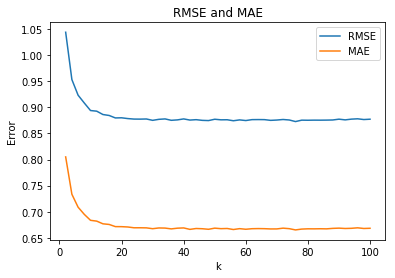

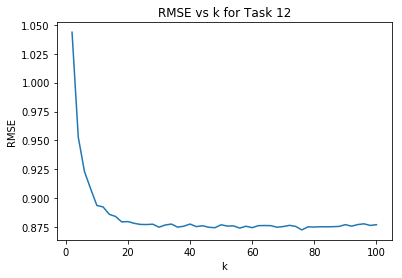

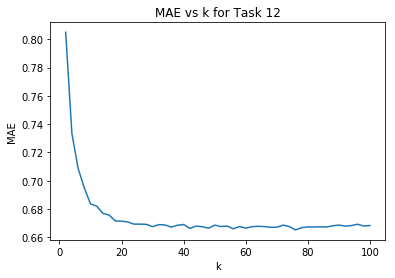

In [4]:
#Task 12
"""
Design a k-NN collaborative filter to predict the ratings of the movies in the popular movie trimmed test set and evaluate it's 
performance using 10-fold cross validation. Sweep k ( number of neighbors) from 2 to 100 in step sizes of 2, and for each k 
compute the average RMSE obtained by averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis). 
Also, report the minimum average RMSE.
"""
reader = Reader(line_format="user item rating timestamp", sep=',',skip_lines=1)
data = Dataset.load_from_file('./ml-latest-small/ratings.csv', reader=reader)
#data = Dataset.load_from_file('C:/Users/ektam/Desktop/Ekta/Subjects/Q2/LargeScaleDataMining/Project3/ml-latest-small/ratings.csv', reader=reader)

kf=KFold(n_splits=10)

meanRMSE_knn_popular=[]
meanMAE_knn_popular=[]
k_arr=[]
for i in range(2,101,2):
    print " for k = "+str(i)
    k_arr.append(i)

    sim_options = {
    'name': 'pearson',
    'user_based': True  
    }
    algo = KNNWithMeans(k=i, sim_options=sim_options,  verbose=False)
    rmse_sub=[]
    mae_sub=[]
    for trainset, testset in kf.split(data):
        algo.fit(trainset)
        testset=getPopular(testset,2)
        predictions=algo.test(testset)
        curr_rmse=accuracy.rmse(predictions, verbose=False)
        rmse_sub.append(curr_rmse)
        mae_sub.append(accuracy.mae(predictions, verbose=False))

    meanRMSE_knn_popular.append(np.mean(rmse_sub))
    meanMAE_knn_popular.append(np.mean(mae_sub))

plot_error(meanRMSE_knn_popular,meanMAE_knn_popular,k_arr,'12')
plotgraph(meanRMSE_knn_popular, k_arr,'RMSE','k','RMSE vs k for Task 12')
plotgraph(meanMAE_knn_popular, k_arr,'MAE','k','MAE vs k for Task 12')


In [5]:
print "Minimum Average RMSE for Popular trimmed testset: "
print min(meanRMSE_knn_popular)
print "**********mean RMSE array for Popular******************"
print "mean RMSE array for Popular trimmed testset" +str(meanRMSE_knn_popular)
print "**********mean RMSE array for Unpopular******************"
print "mean MAE array for Popular trimmed testset" +str(meanMAE_knn_popular)



Minimum Average RMSE for Popular trimmed testset: 
0.87262538252
**********mean RMSE array for Popular******************
mean RMSE array for Popular trimmed testset[1.0436013994173354, 0.95301255834674237, 0.92310517715461526, 0.9081180587330987, 0.89374424725027968, 0.89250205704938179, 0.88609195521649808, 0.88427605055890157, 0.87956494631188986, 0.87982877493565381, 0.87833693972961713, 0.87737137904093276, 0.87728272357045822, 0.87755975724218582, 0.87497985481184271, 0.87688818728705531, 0.87768360431910997, 0.87503484300035017, 0.87583899745957172, 0.87768591267615115, 0.87548547928478848, 0.87623822172172816, 0.87494437857216312, 0.8745339461781112, 0.87705260994382428, 0.87596346278298465, 0.8760897362375909, 0.87418453216597869, 0.87580126160691074, 0.87457415763815105, 0.87631178043229041, 0.87642856322224882, 0.87631669537506229, 0.87494147346054485, 0.87553776915139514, 0.87657626214296813, 0.87563786224985152, 0.87262538252021804, 0.87530986360130802, 0.87514800333985043,

 for k = 2
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
 for k = 4
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done comput

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
 for k = 24
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing simila

 for k = 44
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
 for k = 46
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done comp

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
 for k = 66
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing simila

 for k = 86
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
 for k = 88
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done comp

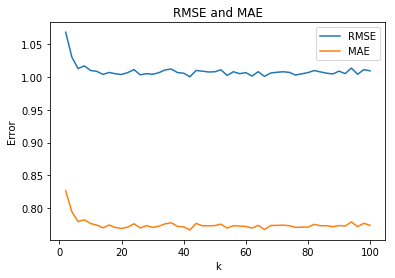

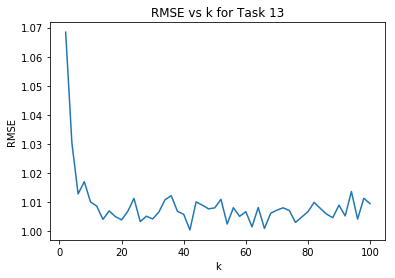

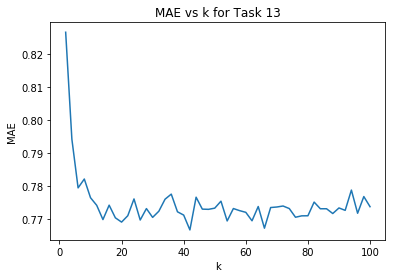

Minimum Average RMSE : 
1.00047636903
mean RMSE array for unpopular trimmed testset[1.0683897341475896, 1.0303843506332573, 1.0128378367989257, 1.0170483934796408, 1.0100693976384172, 1.0086835762887594, 1.0040941925379125, 1.0070071381146593, 1.0050530153294752, 1.003929926386492, 1.0068546266703404, 1.011304284584249, 1.0033513560187273, 1.0051909359392037, 1.0042413348688206, 1.0066059176870155, 1.0108566712489571, 1.0122242646388406, 1.0068490386688489, 1.0058522725684533, 1.0004763690270047, 1.0100907744633489, 1.0090006986922515, 1.0077070333412319, 1.0080559224945389, 1.0109912415586382, 1.0024952355340109, 1.0081156197507528, 1.0051382326922558, 1.0067604156269201, 1.0015356129651143, 1.0081850079601624, 1.0009861269639722, 1.0061703112812648, 1.0072755049587285, 1.0080713910640446, 1.0071565201883086, 1.0030423621701048, 1.0049020860822364, 1.0067186599345817, 1.0099330153734782, 1.0078769896952575, 1.0058980836562985, 1.0046873868949207, 1.0089885996183459, 1.0052805842779517

In [6]:
#Task 13
"""
Design a k-NN collaborative filter to predict the ratings of the movies in the unpopular movie trimmed test set and evaluate
it's performance using 10-fold cross validation. Sweep k ( number of neighbors) from 2 to 100 in step sizes of 2, and for each
k compute the average RMSE obtained by averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis).
Also, report the minimum average RMSE.
"""
from surprise import Reader, Dataset,accuracy
from surprise import KNNBasic,evaluate
from surprise.model_selection import cross_validate
import numpy as np
from surprise.model_selection import KFold
#import surprise
# Define the format

reader = Reader(line_format="user item rating timestamp", sep=',',skip_lines=1)
data = Dataset.load_from_file('./ml-latest-small/ratings.csv', reader=reader)

kf=KFold(n_splits=10)

meanRMSE_knn_unpopular=[]
meanMAE_knn_unpopular=[]
k_arr=[]
for i in range(2,101,2):
    print " for k = "+str(i)
    k_arr.append(i)
    sim_options = {
    'name': 'pearson',
    'user_based': True  
    }
    algo = KNNWithMeans(k=i, sim_options=sim_options)
    rmse_sub=[]
    mae_sub=[]
    for trainset, testset in kf.split(data):
        algo.fit(trainset)
        testset=getUnpopular(testset,2)
        predictions=algo.test(testset)
        #print testset
        curr_rmse=accuracy.rmse(predictions, verbose=False)
        rmse_sub.append(curr_rmse)
        mae_sub.append(accuracy.mae(predictions, verbose=False))

    meanRMSE_knn_unpopular.append(np.mean(rmse_sub))
    meanMAE_knn_unpopular.append(np.mean(mae_sub))
plot_error(meanRMSE_knn_unpopular,meanMAE_knn_unpopular,k_arr,'13')
plotgraph(meanRMSE_knn_unpopular, k_arr,'RMSE','k','RMSE vs k for Task 13')
plotgraph(meanMAE_knn_unpopular, k_arr,'MAE','k','MAE vs k for Task 13')
print "Minimum Average RMSE : " 
print min(meanRMSE_knn_unpopular)
print "mean RMSE array for unpopular trimmed testset" +str(meanRMSE_knn_unpopular)
print "mean MAE array for unpopular trimmed testset" +str(meanMAE_knn_unpopular)

In [7]:
print min(meanRMSE_knn_unpopular)

1.00047636903


 for k = 2
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
 for k = 4
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done comput

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
 for k = 24
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing simila

 for k = 44
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
 for k = 46
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done comp

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
 for k = 66
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing simila

 for k = 86
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
 for k = 88
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done comp

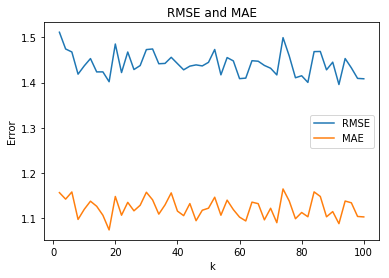

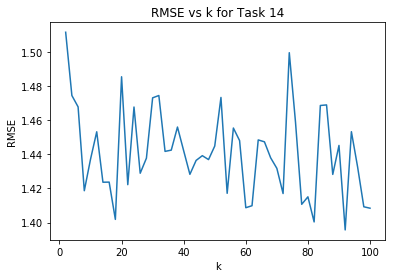

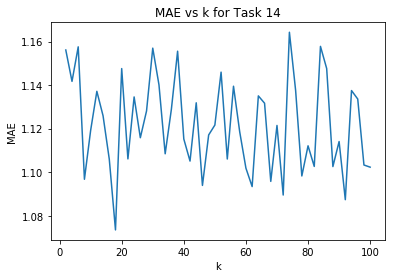

Minimum Average RMSE : 
1.39571324499
mean RMSE array for High Variance trimmed testset[1.5115542517193945, 1.4744764120153104, 1.4678246214881043, 1.4186806403035075, 1.4371096011592379, 1.4532248046225216, 1.4236612651495204, 1.4237298504878926, 1.4018790756616519, 1.4854638952344199, 1.4222320320169595, 1.4677332958794609, 1.4289319805426672, 1.4377449411270089, 1.4731169693351465, 1.4744810298590179, 1.4417322462648894, 1.4424708131672768, 1.4559983708247493, 1.4420691023028203, 1.4282877585150779, 1.4364348945918208, 1.439219612282346, 1.436924977066607, 1.44486152862765, 1.4733427085959199, 1.4171626647653073, 1.4554247970279546, 1.4480618411145905, 1.408727548931507, 1.4098938401770482, 1.4484511349422602, 1.4473382120058489, 1.4379676237392309, 1.4317920932127914, 1.4170323106381457, 1.4995687720900066, 1.4589253378992051, 1.4107225427363013, 1.4151013920260447, 1.4003972514229255, 1.4686293253475982, 1.4689683931267477, 1.4282445549092297, 1.4452226169146525, 1.395713244994925

In [8]:
#task 14

"""

Design a k-NN collaborative filter to predict the ratings of the movies in the high variance movie trimmed test set and evaluate
it's performance using 10-fold cross validation. Sweep k ( number of neighbors) from 2 to 100 in step sizes of 2, and for each
k compute the average RMSE obtained by averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis).
Also, report the minimum average RMSE.

"""
from surprise import Reader, Dataset,accuracy
from surprise import KNNBasic,evaluate, KNNWithMeans



from surprise.model_selection import KFold

reader = Reader(line_format="user item rating timestamp", sep=',',skip_lines=1)
#data = Dataset.load_from_file('./ml-latest-small/ratings.csv', reader=reader)
data = Dataset.load_from_file('C:/Users/ektam/Desktop/Ekta/Subjects/Q2/LargeScaleDataMining/Project3/ml-latest-small/ratings.csv', reader=reader)
kf=KFold(n_splits=10)
meanRMSE_knn_hv=[]
meanMAE_knn_hv=[]
k_arr=[]
for i in range(2,101,2):
    print " for k = "+str(i)
    k_arr.append(i)

    sim_options = {
    'name': 'pearson',
    'user_based': True  
    }
    algo = KNNWithMeans(k=i, sim_options=sim_options, verbose=False)
    rmse_sub=[]
    mae_sub=[]
    for trainset, testset in kf.split(data):
        algo.fit(trainset)
        testset=getHighVariance(testset)
        predictions=algo.test(testset)
        curr_rmse=accuracy.rmse(predictions, verbose=False)
        rmse_sub.append(curr_rmse)
        mae_sub.append(accuracy.mae(predictions, verbose=False))
    
    meanRMSE_knn_hv.append(np.mean(rmse_sub))
    meanMAE_knn_hv.append(np.mean(mae_sub))
    
plot_error(meanRMSE_knn_hv,meanMAE_knn_hv,k_arr,'14')  
plotgraph(meanRMSE_knn_hv, k_arr,'RMSE','k','RMSE vs k for Task 14')
plotgraph(meanMAE_knn_hv, k_arr,'MAE','k','MAE vs k for Task 14')
print "Minimum Average RMSE : " 
print min(meanRMSE_knn_hv)
print "mean RMSE array for High Variance trimmed testset" +str(meanRMSE_knn_hv)
print "mean MAE array for High Variance trimmed testset" +str(meanMAE_knn_hv)

Computing the pearson similarity matrix...
Done computing similarity matrix.
ROC curve


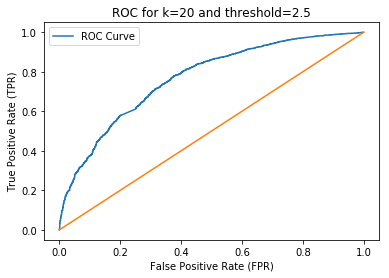

 Area under ROC for k=20 and threshold=2.5
0.767006456542
ROC curve


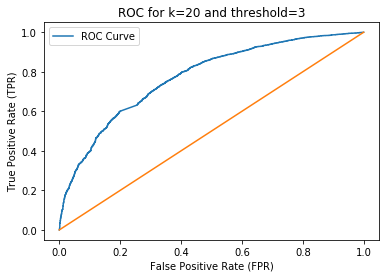

 Area under ROC for k=20 and threshold=3
0.772619108769
ROC curve


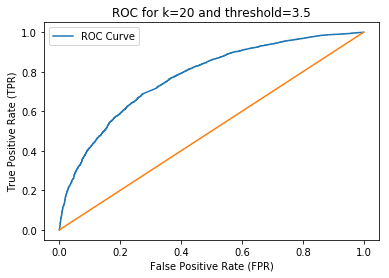

 Area under ROC for k=20 and threshold=3.5
0.774224845435
ROC curve


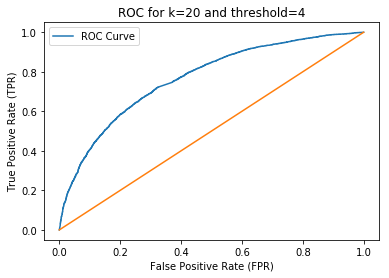

 Area under ROC for k=20 and threshold=4
0.76628683927


In [9]:
#Task 15
"""
Plot the ROC curves for the k-NN collaborative alter designed in question 10 for threshold values [2:5; 3; 3:5; 4]. 
For the ROC plotting use the k found in question 11. For each of the plots, also report the area under the curve (AUC) value.
"""
from surprise.model_selection import train_test_split

reader = Reader(line_format="user item rating timestamp", sep=',',skip_lines=1)
data = Dataset.load_from_file('./ml-latest-small/ratings.csv', reader=reader)
#data = Dataset.load_from_file('C:/Users/ektam/Desktop/Ekta/Subjects/Q2/LargeScaleDataMining/Project3/ml-latest-small/ratings.csv', reader=reader)
sim_options = {
'name': 'pearson',
'user_based': True  
}
trainset, testset = train_test_split(data, test_size=.10)
list_est=[]
algo = KNNWithMeans(k=22, sim_options=sim_options)

algo.fit(trainset)
predictions = algo.test(testset)
pred = np.array(predictions)[:,3]
#for uid, iid, true_r, est, _ in predictions:
 #   list_est.append(est)
testset_i=np.array(testset)[:,2]
#testset_i = map(float, testset_i)

#threshold=3
for threshold in [2.5,3,3.5,4]:
    testset_n=classify_into_two_class(testset_i,threshold)
    print "ROC curve"
    plot_roc(testset_n,pred, "ROC for k=20 and threshold="+str(threshold))
    print" Area under ROC for k=20 and threshold="+str(threshold)
    print roc_auc_score(testset_n,pred)


Computing for k= 1
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
[0.8203968541124202]
[0.23365080122990944]
Computing for k= 2
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done

[0.8203968541124202, 0.7922693363407775, 0.7789772599600086, 0.7670740294616156, 0.764610635836179, 0.7618170857519446, 0.762078711448584, 0.7591383859796221, 0.7588452330067812]
[0.23365080122990944, 0.3719011792496797, 0.4505749563115364, 0.4943095515513248, 0.5215165667087142, 0.5395856460785895, 0.5549377894314265, 0.5628147111415457, 0.5790744681992261]
Computing for k= 10
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
[0.8203968541124202, 0.7922693363407775, 0.7789772599600086, 0.7670740294616156, 0.764610635836179, 0.7618170857519446, 0.762078711448584, 0.7591383859796221, 0.7588452330067812, 0.7551175320635124, 0.7551789834434667, 0.7517683543624816, 0.7519284992218596, 0.7472110310743478, 0.7467693829501927, 0.743936283381692]
[0.23365080122990944, 0.3719011792496797, 0.4505749563115364, 0.4943095515513248, 0.5215165667087142, 0.5395856460785895, 0.5549377894314265, 0.5628147111415457, 0.5790744681992261, 0.5909169291349261, 0.6038013733770413, 0.616951991833807, 0.619114494171478, 0.6297261965939245, 0.6351248005786689, 0.640418904688038

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
[0.8203968541124202, 0.7922693363407775, 0.7789772599600086, 0.7670740294616156, 0.764610635836179, 0.7618170857519446, 0.762078711448584, 0.7591383859796221, 0.7588452330067812, 0.7551175320635124, 0.7551789834434667, 0.7517683543624816, 0.7519284992218596, 0.747211031

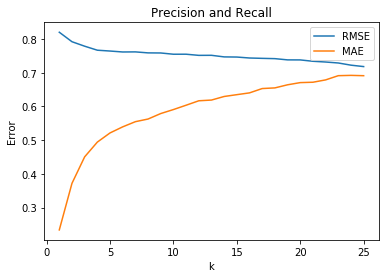

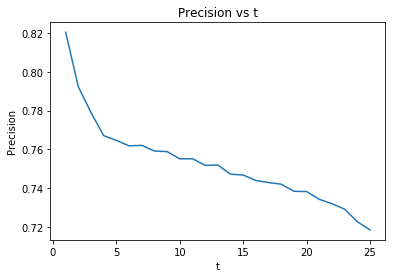

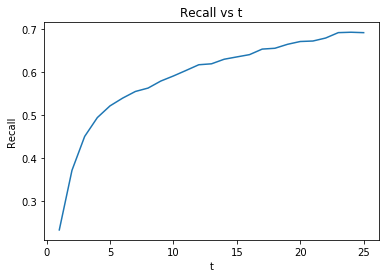

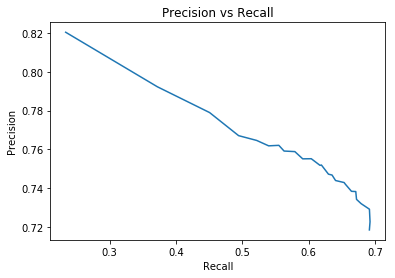

In [12]:
#Task 34
"""
Plot average precision (Y-axis) against t (X-axis) for the ranking obtained using k-NN collaborative alter predictions. Also, 
plot the average recall (Y-axis) against t (X-axis) and average precision (Y-axis) against average recall (X-axis). Use the 
k found in question 11 and sweep t from 1 to 25 in step sizes of 1. For each plot, briefly comment on the shape of the plot.
"""
from collections import defaultdict

reader = Reader(line_format="user item rating timestamp", sep=',',skip_lines=1)
#data = Dataset.load_from_file('./ml-latest-small/ratings.csv', reader=reader)
data = Dataset.load_from_file('C:/Users/ektam/Desktop/Ekta/Subjects/Q2/LargeScaleDataMining/Project3/ml-latest-small/ratings.csv', reader=reader)
recall=[]
precision=[]
t_arr=[]
for i in range(1,26):
    print "Computing for k=",i
    t_arr.append(i)
    algo=KNNWithMeans(n_factors=22, verbose=False)
    kf = KFold(n_splits=10)
    prec=0
    rec=0

    for trainset, testset in kf.split(data):
        algo.fit(trainset)
        predictions = algo.test(testset)
        p,r=getPR(predictions,i)
        prec=prec+p
        rec=rec+r
        #print "precision ",p," recall ",r
    precision.append(prec/10)
    recall.append(rec/10)
    print precision
    print recall
    
plot_PR_against_t(precision,recall, t_arr,'Precision Recall vs t for Task34')
plotgraph(precision, t_arr,'Precision','t','Precision vs t')
plotgraph(recall, t_arr,'Recall','t','Recall vs t')
plotgraph(precision, recall,'Precision','Recall','Precision vs Recall')

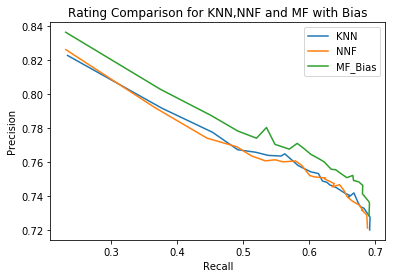

In [13]:
# task 39
#The below arrays were obtained after performing Ranking Tasks from Question 35,36,37
nnf_prec=[0.8262241852602976, 0.7922055595017544, 0.7741884331535035, 0.7691199939664124, 0.7637886319940591, 0.76082216527427, 0.7614557423101711, 0.7602247313342562, 0.7607793415733172, 0.7581664779259492, 0.7522281281266845, 0.751386529850039, 0.750769573998149, 0.7502272884062012, 0.7474324905227909, 0.7455126905694879, 0.7468340482131396, 0.7433172476885892, 0.739665306476968, 0.7371267092680602, 0.7348655813186417, 0.7318638800954597, 0.7320351136593038, 0.7290139632633876, 0.7213330544229628]
nnf_rec=[0.23140058592673124, 0.3661661191970461, 0.44547273931768966, 0.49057586407631676, 0.5126608633420704, 0.5340167967360762, 0.5489059808300618, 0.5610473703332844, 0.5797333235451828, 0.5891149211582334, 0.6011941045614203, 0.6082744672179697, 0.6249886714771464, 0.6236832824874444, 0.6384597329639745, 0.6353243158508621, 0.646373257046527, 0.653378321153797, 0.6580587133479521, 0.6660594650130235, 0.6762140482869248, 0.6815275571729229, 0.6799329862621545, 0.6877545234570588, 0.6888007499432763]
knn_prec=[0.8228216912512524,
 0.7918176547700366,
 0.7776788169179006,
 0.7673728402911666,
 0.7658704066892604,
 0.7640590493700683,
 0.763638909553881,
 0.7649608371481843,
 0.7581224089232712,
 0.7564631382214851,
 0.7543288661335905,
 0.7533450925719533,
 0.7489544455884967,
 0.748225211258333,
 0.7466351751920561,
 0.745165081638825,
 0.7419058818596334,
 0.7405627589246971,
 0.7394639728192396,
 0.7419605029070626,
 0.7359715319985749,
 0.7337399037445306,
 0.7330827407004253,
 0.7277037499836416,
 0.7202163146605518]
knn_rec=[0.23397101866481168,
 0.3769087912768686,
 0.45360625145239375,
 0.49200674544725775,
 0.519593909604009,
 0.5379760973083351,
 0.5575715234946366,
 0.5633559801404255,
 0.5834798105606859,
 0.5918510643056528,
 0.6031195360189218,
 0.6143835673841345,
 0.620550043817158,
 0.6271208679144836,
 0.6318012414833699,
 0.6411856552953652,
 0.654225705593517,
 0.661562064096417,
 0.6600409131178666,
 0.6682604357636105,
 0.674888837943614,
 0.6784552496720848,
 0.6831330337043056,
 0.692661464328584,
 0.6920771384104528]
mf_prec=[0.8364537831255141,
 0.8028711708871766,
 0.7875514464094009,
 0.7783856280582337,
 0.7741465946303644,
 0.7804354465952017,
 0.7705025185447008,
 0.7677220550487907,
 0.7710990361462098,
 0.7676442729592734,
 0.7646418412028823,
 0.7615685565054182,
 0.7601389023366828,
 0.7559099533878684,
 0.7555677832968855,
 0.7537473556007448,
 0.7509377264470758,
 0.7522687993236826,
 0.7493195136225032,
 0.7484290670366084,
 0.7464103308084181,
 0.7414136772798853,
 0.7369297404240382,
 0.7358268491228146,
 0.7286502581141219]
mf_rec=[0.23115359799458815,
 0.374968311175535,
 0.4514952129433866,
 0.49204128545149645,
 0.5205070085611243,
 0.535624668556958,
 0.5485900505289021,
 0.5702349074186851,
 0.5822112313920544,
 0.5937746360345272,
 0.6029876696177976,
 0.6174890731249374,
 0.6233407290840073,
 0.6336872932334081,
 0.6408086809455308,
 0.6470375933806525,
 0.6575602404163055,
 0.6665502843710406,
 0.6676590164033371,
 0.6757064906101863,
 0.6815855929840378,
 0.6812081298746827,
 0.6907745873334993,
 0.6918235108041835,
 0.6911565584550571]
all_plots_rating(knn_prec, knn_rec, nnf_prec, nnf_rec, mf_prec,mf_rec)


Computing the pearson similarity matrix...
Done computing similarity matrix.
ROC curve


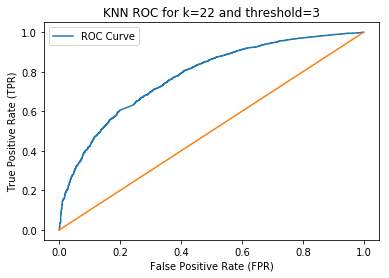

 Area under ROC for k=22 and threshold=3
0.777699918047


In [15]:
# for task 34 KNN

from surprise.model_selection import train_test_split

reader = Reader(line_format="user item rating timestamp", sep=',',skip_lines=1)
data = Dataset.load_from_file('./ml-latest-small/ratings.csv', reader=reader)

sim_options = {
'name': 'pearson',
'user_based': True  
}
trainset, testset = train_test_split(data, test_size=.10)
list_est=[]
algo = KNNWithMeans(k=22, sim_options=sim_options)

algo.fit(trainset)
predictions = algo.test(testset)
pred_knn = np.array(predictions)[:,3]
#for uid, iid, true_r, est, _ in predictions:
 #   list_est.append(est)
testset_i=np.array(testset)[:,2]
#testset_i = map(float, testset_i)

threshold=3
#for threshold in [2.5,3,3.5,4]:
testset_knn=classify_into_two_class(testset_i,threshold)
print "ROC curve"
plot_roc(testset_knn,pred_knn, "KNN ROC for k=22 and threshold="+str(threshold))
print" Area under ROC for k=22 and threshold="+str(threshold)
print roc_auc_score(testset_knn,pred_knn)


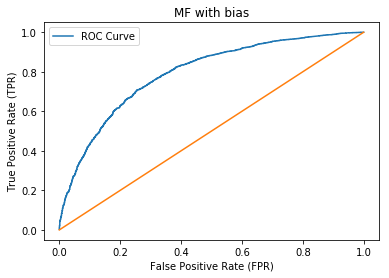

Area under ROC =  0.792052483074


In [16]:
#for task 34 MF with Bias
from surprise import Reader, Dataset, SVD
trainset, testset = train_test_split(data, test_size=0.1, random_state=42)
algo = SVD(n_factors = 14, random_state = 37)
algo.fit(trainset)
predictions = algo.test(testset)

testarray = np.array(testset)[:,2]

threshold=3
test_mf = classify_into_two_class(testarray,threshold)
pred_mf = np.array(predictions)[:,3]
plot_roc(test_mf, pred_mf, "MF with bias")

auc = roc_auc_score(test_mf,pred_mf)
print 'Area under ROC = ', auc

ROC curve


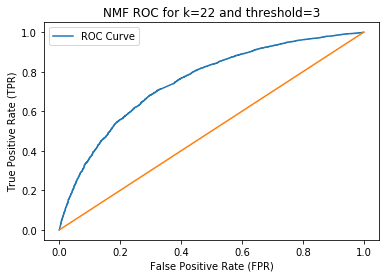

 Area under ROC for k=22 and threshold=3
0.751512765699


In [17]:
#NNF for Task 34
from surprise.prediction_algorithms.matrix_factorization import NMF
algo=NMF(n_factors=22)
trainset_nmf, testset_nmf = train_test_split(data, test_size=.10)
algo.fit(trainset_nmf)
predictions = algo.test(testset_nmf)
actual=[]
pred_nnf=[]
for uid, iid, true_r, est, _ in predictions:
    pred_nnf.append(est)
actual=np.array(testset_nmf)[:,2]
actual = map(float, actual)

threshold=3
testset_nmf=map(lambda x: 1 if x>threshold else 0,actual)
print "ROC curve"
plot_roc(testset_nmf,pred_nnf, "NMF ROC for k=22 and threshold="+str(threshold))
print" Area under ROC for k=22 and threshold="+str(threshold)
print roc_auc_score(testset_nmf,pred_nnf)

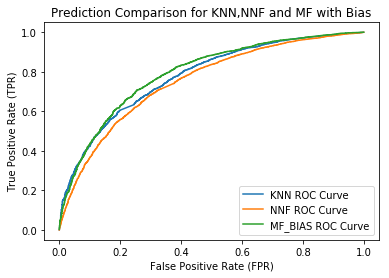

In [18]:
all_plots_roc(testset_knn, pred_knn,testset_nmf,pred_nnf,test_mf, pred_mf)